感知机（英语：Perceptron）是Frank Rosenblatt在1957年就职于Cornell航空实验室(Cornell Aeronautical Laboratory)时所发明的一种人工神经网络。它可以被视为一种最简单形式的前馈式人工神经网络，是一种二元线性分类器。它虽然简单，但是应用却非常广泛。本文将解释基本原理，并尝试用Spark+Python实现这个算法，使之能够分布方式执行。


Remaining:
1. Pocket-PLA 加上噪音
2. Spark + Python
3. 需要加上参考的文档。


# 基本原理
## 概念
感知机学习的基本前提是数据是线性可分的，也就是两个类别的数据可以被一个超平面分开。

![pla_1](https://raw.githubusercontent.com/xuxiangwen/python-book/master/resources/image/pla/pla_1.png)

超平面的数学公式是 $$w\cdot x + b$$
空间任何一点是否处于平面某一边可以用公式来判断$$sign(w\cdot x + b)$$
可以这么理解这个公式，首先对超平面做一个坐标变化，把坐标原点变换到$$(0, 0, 0 ,-w_i/b , 0, 0)$$
这样超平面公式变成$$w\cdot x$$
在这个变换后的空间里，对于某个向量，如果 $w\cdot x$ 大于0，意味着这个向量和 $w$ 的夹角小于90度，也就是这个向量对应的点位于超平面上方，反之，如果 $w\cdot x$ 小于0，意味着这个向量和 $w$ 的夹角小于90度, 也就是这个点位于超平面的下方。

## 假设（Hypothesis）

如上文所述，PLA的公式是：$$ h(X) = sign(w\cdot x + b) $$
如过每个 x 是一个 d 维向量。公式可以写成：$$ h(X) = sign(\sum_{i=1}^d w_i*x_i + b)  $$
对于上文中的超平面公式，如果我们让 $$ w_0=b , x_0=1$$

公式变成：$$ h(X) = sign(\sum_{i=0}^d w_i*x_i)  $$

也就是：$$ h(X) = sign(w\cdot x)  $$

这里的公式和上节中的形式虽然相似，但意义不同，上节中对原始$x$做了一个坐标变换，而本节增加了一个维度。之所以这么做的原因是，对于$w$和$b$都是变量，所以上节中$w_i/b$可以是任意值的，无法进行计算。而在对原始$x$增加一个固定的值$1$后，能够把$w$求解出来。

## PLA算法

一直修正向量W，直到向量W满足所有数据为止。

$for\ t = 0, 1, ... $
  
$\qquad 如果存在一个x满足$

$\qquad if\ \ sign(w\cdot x) \neq y $ 

$\qquad \qquad w_{t+1} = w_t + y\cdot x$ 

$\qquad else $

$\qquad \qquad break$

$w$的更新逻辑：
![pla_2](https://github.com/xuxiangwen/python-book/raw/master/resources/image/pla/pla_2.png)


## Pocket PLA
上节的算法也称之为Naive PLA， Naive PLA的一大问题就是如果数据有杂音，不能完美的分类的话，算法就不会中止。所以对于有噪音的数据，我们只能期望找到错误最少的结果。然后这是一个NP Hard问题。 Pocket PLA一个贪心的近似算法。和Naive PLA算法类似。变顺序迭代为随机迭代，如果找出错误，则修正结果。在修正过程中，记录犯错误最少的向量。

$ error_{min} = 1 $ 

$ w_{min} = 0  $  

$for\ t = 0, 1, ...,n $

$\qquad error_{t} = count(sign(w\cdot x) \neq y)/count(y) $ 

$\qquad if\ \ error_{t} > 0 $ 

$\qquad \qquad if\ \ error_{t} < error_{min} $ 

$\qquad \qquad \qquad error_{min} = error_{t} $

$\qquad \qquad \qquad w_{min} = w_t $

$\qquad \qquad 使用任意一个错分类的点来更新w$

$\qquad \qquad w_{t+1} = w_t + y\cdot x$ 

$\qquad else $

$\qquad \qquad error_{min} = error_{t} $

$\qquad \qquad w_{min} = w_t$

$\qquad \qquad break$


## w优化的本质

以上算法描述中，每次只更新一个点，其实也可以更新所有的错误分类的点，或者若干个错误分类的点。本质上，PLA就是对以下函数求最小值的过程。
$$L(w) = \sum_{i=1}^n sign(w\cdot t-y)$$
而这个优化过程可以转化成下面公式
$$w = w + \alpha \nabla F$$
也就是
$$w = w + \alpha \sum_{i=1}^k \nabla sign(w\cdot t-y)$$
根据k的值不同，可以分为：
* $k = n$：Batch Gradient Descent（批量梯度下降）
* $k = 1$：Stochastic Gradient Descent（随机梯度下降）
* $k > 1\ and\ k < n$：Mini-batch Gradient Descent（小批量梯度下降）

# 算法实现
## 基本实现

Create own target function $f$ and data set $D$ to see
how the Perceptron Learning Algorithm works. Take $d = 2$ so you can visualize the
problem, and assume $X = [−1,1] × [−1,1]$ with uniform probability of picking each
$x ∈ X$.

In each run, choose a random line in the plane as your target function $f$ (do this by
taking two random, uniformly distributed points in $[−1,1] × [−1,1]$ and taking the
line passing through them), where one side of the line maps to +1 and the other maps
to −1. Choose the inputs $x_n$ of the data set as random points (uniformly in $X$), and
evaluate the target function on each $x_n$ to get the corresponding output $y_n$.

Now, in each run, use the Perceptron Learning Algorithm to find $g$. Start the PLA
with the weight vector w being all zeros (consider $sign(0) = 0$, so all points are initially misclassified), and at each iteration have the algorithm choose a point randomly
from the set of misclassified points. We are interested in two quantities: the number
of iterations that PLA takes to converge to $g$, and the disagreement between $f$ and
$g$ which is $\mathbb{P}[f(x) \neq g(x)]$ (the probability that $f$ and $g$ will disagree on their classification of a random point). You can either calculate this probability exactly, or
approximate it by generating a sufficiently large, separate set of points to estimate it.

In order to get a reliable estimate for these two quantities, you should repeat the
experiment for 1000 runs (each run as specified above) and take the average over
these runs.

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
%matplotlib inline

### Base Functions

In [2]:

def standard_weights(weights):
    return weights/math.sqrt(np.sum(weights ** 2))


def random_split(data, rate):
    train_count = int(round(len(data) * rate))
    train = data[0:train_count]
    test = data[train_count:]
    return train, test


def get_numpy_data(data, features, output):
    """
    convert pandas dataframe to numpy array
    add 1 to feature_matrix
    """
    feature_matrix = data.loc[:, features].as_matrix()
    output_array = data.loc[:, output].as_matrix()
    constant = np.ones((len(data), 1))
    feature_matrix = np.hstack((constant, feature_matrix))
    return feature_matrix, output_array


def perceptron_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights) > 0
    return (predictions>0)*2-1


def get_experiment_weights(d):
    w = np.random.rand(d)
    w /= math.sqrt(np.sum(w ** 2))
    i = np.random.randint(0,d)
    w0 = np.random.rand(1) * w[i]
    weights = np.hstack((w0, w))
    return standard_weights(weights)


def get_experiment_dataframe(n, d, weight):
    """
    get pandas get_experiment_dataframe
    """
    x0 = np.ones((n,1))
    x = np.random.rand(n, d)*2-1
    x = np.hstack((x0, x))
    y = perceptron_output(x, weight)
    y.shape = (n, 1)
    data = np.hstack((x, y))
    df = pd.DataFrame(data[:,1:(d+2)])
    df.columns = ['x'+str(i+1) for i in range(d)] + ['y']
    return df


def get_experiment_data(n, d):
    """
    get pandas data and weights
    """
    rate = 0.5
    features = ['x' + str(i + 1) for i in range(d)]
    output = 'y'
    weights = get_experiment_weights(d)
    data = get_experiment_dataframe(n, d, weights)
    train, test = random_split(data, rate)
    return train, test, features, output, weights


### Perceptron

In [3]:

def get_classification_accuracy(feature_matrix, weights, output):
    predicts = perceptron_output(feature_matrix, weights)
    return np.sum(output == predicts)/float(len(output))


def update_weights(feature_matrix, output, weights, choose_first_error):
    if np.all(weights == 0):
        error_indexes = np.arange(len(feature_matrix))
    else:
        predictions = perceptron_output(feature_matrix, weights)
        error_indexes = np.where(predictions != output)[0]
    error_count = len(error_indexes)
    if error_count == 0:
        return weights, error_indexes, 0
    if choose_first_error:
        index = 0
    else:
        index = np.random.randint(error_count)
    error_index = error_indexes[index]
    return weights + feature_matrix[error_index]*output[error_index], error_indexes, error_index


def pla(feature_matrix, output, weights_initial, step=False, choose_first_error=False):
    weights = weights_initial
    iteration = 0
    while True:
        iteration += 1
        if step:
            print('-------------------{0}-------------------'.format(iteration))
        weights, error_indexes, error_index = update_weights(feature_matrix, output, weights, choose_first_error)
        error_count = len(error_indexes)
        if step:
            print('weights = {0}, error_count = {1}'.format(weights, error_count))
            print('error_index = {0}, error_vector = {1}, error_output = {2}'.format(
                error_index, feature_matrix[error_index], output[error_index]))
        if error_count == 0:
            break
    weights = standard_weights(weights)
    return weights, iteration


def get_y(x, weights):
    y = -weights[0]/weights[2] - weights[1]*x/weights[2]
    return y


animation_iteration = 0
animation_error_count = 0
animation_weights = np.array([])


def pla_animation(feature_matrix, output, weights, weights_initial, choose_first_error=False):
    global animation_weights, animation_error_count, animation_iteration
    animation_weights = weights_initial
    animation_iteration = 0
    animation_error_count = len(feature_matrix)

    x = feature_matrix[:, 1]
    y = feature_matrix[:, 2]
    color = output

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(xlim=(-4, 4), ylim=(-4, 4))
    ax.grid(True)

    line_x = np.array([-2, 2])
    line_y = get_y(line_x, weights)
    line = ax.plot(line_x, line_y, color='black', linewidth=2)
    plt.annotate('', xy=weights[1:], xytext=(0, 0),
                 arrowprops=dict(linewidth=2.0, color='black', arrowstyle="->", connectionstyle="arc3"))
    plt.annotate(' origin weights = {0}'.format(weights), xy=(0, 0), xytext=(-3.8, 3.8))
    scat = ax.scatter(x, y, s=50, c=color, alpha=.5)

    def init():
        return scat,

    def animate(frame):
        global animation_weights, animation_error_count, animation_iteration
        if animation_error_count > 0:
            animation_iteration += 1
            anno_weights_prev = plt.annotate('', xy=animation_weights[1:], xytext=(0, 0),
                                             arrowprops=dict(linewidth=2, color='blue', arrowstyle="->",
                                                             connectionstyle="arc3"))
            animation_weights, error_indexes, error_index = update_weights(feature_matrix, output, animation_weights,
                                                                           choose_first_error=choose_first_error)
            animation_error_count = len(error_indexes)
            error_xy = (feature_matrix[error_index, 1], feature_matrix[error_index, 2])
            anno_error = plt.annotate('', xy=error_xy, xytext=(0, 0),
                                      arrowprops=dict(linewidth=2, color='red', arrowstyle="->",
                                                      connectionstyle="arc3"))
        weights_text = 'current weights = {0}'.format(standard_weights(animation_weights))
        anno_current_weights = plt.annotate(weights_text, xy=(0, 0), xytext=(-3.8, 3.6))
        title_text = 'iteration = {0}, error_count = {1}'.format(animation_iteration, animation_error_count)
        anno_title = plt.annotate(title_text, xy=(0, 0), xytext=(-3.8, 3.4))
        anno_weights = plt.annotate('', xy=animation_weights[1:], xytext=(0, 0),
                                    arrowprops=dict(linewidth=2, color='green', arrowstyle="->",
                                                    connectionstyle="arc3"))
        if animation_error_count > 0:
            return scat, anno_current_weights, anno_title, anno_error, anno_weights_prev, anno_weights,
        else:
            current_line_x = np.array([-3, 3])
            y1 = get_y(-3, standard_weights(animation_weights))
            y2 = get_y(3, standard_weights(animation_weights))
            anno_line = plt.annotate('', xy=(-3, y1), xytext=(3, y2),
                                        arrowprops=dict(linewidth=2, color='green', arrowstyle="-"))
            return scat, anno_line, anno_current_weights, anno_title, anno_weights,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=1000, blit=True)
    plt.show()


### Perceptron Experiment

In [4]:
def run_pla(time, n, d, step=False, choose_first_error=False):
    train, test, features, output, weights = get_experiment_data(n, d)
    weights_initial = np.zeros(d + 1)
    train_features, train_output = get_numpy_data(train, features, output)
    test_features, test_output = get_numpy_data(test, features, output)

    if time == 1 or time % 100 == 0:
        print('========================{0}========================='.format(time))
    weights, iteration = pla(train_features, train_output, weights_initial, step=step,
                             choose_first_error=choose_first_error)
    train_accuracy = get_classification_accuracy(train_features, weights, train_output)
    test_accuracy = get_classification_accuracy(test_features, weights, test_output)
    if time == 1 or time % 100 == 0:
        print('iteration={0}, train_accuracy={1}, test_accuracy={2} '.format(iteration, train_accuracy, test_accuracy))
    return iteration, train_accuracy, test_accuracy


def run_pla_animation(n, d, choose_first_error=False):
    if d != 2:
        print('d should be 2')
        return
    train, test, features, output, weights = get_experiment_data(n, d)
    weights_initial = np.zeros(d + 1)
    train_features, train_output = get_numpy_data(train, features, output)
    pla_animation(train_features, train_output, weights, weights_initial, choose_first_error)


def run_plas(times, n, d, choose_first_error=False):
    results = np.transpose(np.array(zip(*[run_pla(i+1, n, d, choose_first_error=choose_first_error) for i in range(times)])))
    info = pd.DataFrame(results)
    info.columns = ['iteration', 'train_accuracy', 'test_accuracy']
    return info


def main():
    times = 1000
    n = 200
    d = 2

    info = run_plas(times, n, d, choose_first_error=False)
    info1 = run_plas(times, n, d, choose_first_error=True)

    print('\n\ntimes={0}, n={1}, d={2}, choose_first_error={3}'.format(times, n, d, False))
    print(info.describe())
    print('\n\ntimes={0}, n={1}, d={2}, choose_first_error={3}'.format(times, n, d, True))
    print(info1.describe())


def test_pla():
    n = 20
    d = 2
    #run_pla(0, n, d, step=True)
    run_pla_animation(n, d)

### Question 1
Take $N = 10$. How many iterations does it take on average for the PLA to
converge for $N = 10$ training points? 

In [5]:
times = 1000
n = 20   #the proportion of train and error is 1:1
d = 2
info_10 = run_plas(times, n, d, choose_first_error=False)

========================1=========================
iteration=3, train_accuracy=1.0, test_accuracy=0.9 
========================100=========================
iteration=10, train_accuracy=1.0, test_accuracy=0.8 
========================200=========================
iteration=9, train_accuracy=1.0, test_accuracy=1.0 
========================300=========================
iteration=14, train_accuracy=1.0, test_accuracy=0.7 
========================400=========================
iteration=2, train_accuracy=1.0, test_accuracy=0.9 
========================500=========================
iteration=9, train_accuracy=1.0, test_accuracy=1.0 
========================600=========================
iteration=3, train_accuracy=1.0, test_accuracy=0.9 
========================700=========================
iteration=5, train_accuracy=1.0, test_accuracy=0.8 
========================800=========================
iteration=7, train_accuracy=1.0, test_accuracy=0.7 
========================900=========================
it

ValueError: Must pass 2-d input

In [ ]:
print('times={0}, n={1}, d={2}, choose_first_error={3}'.format(times, n, d, False))
print(info_10.describe())

### Question 2
Take $N = 100$. How many iterations does it take on average for the PLA to
converge for $N = 100$ training points? 

In [9]:
times = 1000
n = 200   #the proportion of train and error is 1:1
d = 2
info_100 = run_plas(times, n, d, choose_first_error=False)

========================1=========================
iteration=64, train_accuracy=1.0, test_accuracy=0.96 
========================100=========================
iteration=39, train_accuracy=1.0, test_accuracy=0.99 
========================200=========================
iteration=16, train_accuracy=1.0, test_accuracy=0.99 
========================300=========================
iteration=4, train_accuracy=1.0, test_accuracy=0.99 
========================400=========================
iteration=662, train_accuracy=1.0, test_accuracy=0.99 
========================500=========================
iteration=1490, train_accuracy=1.0, test_accuracy=0.98 
========================600=========================
iteration=6, train_accuracy=1.0, test_accuracy=0.94 
========================700=========================
iteration=73, train_accuracy=1.0, test_accuracy=1.0 
========================800=========================
iteration=15, train_accuracy=1.0, test_accuracy=0.98 
========================900============

In [10]:
print('times={0}, n={1}, d={2}, choose_first_error={3}'.format(times, n, d, False))
print(info_100.describe())

times=1000, n=200, d=2, choose_first_error=False
          iteration  train_accuracy  test_accuracy
count   1000.000000          1000.0    1000.000000
mean     137.131000             1.0       0.986130
std      534.365963             0.0       0.015974
min        2.000000             1.0       0.870000
25%       31.000000             1.0       0.980000
50%       62.000000             1.0       0.990000
75%      119.250000             1.0       1.000000
max    14456.000000             1.0       1.000000


当测试集的数量是10，测试准确度在90%左右，当测试集的数量是100，测试准确度在99%左右，这说明随着数据量的增加，测试集的准确度越来越高。简单的说，数据量越大，模型的准确度越高。但其深层次的原因在什么地方呢？

### 可视化($d=2$)
以下代码在ipython notebook中运行无法显示动画。不知道是何原因。

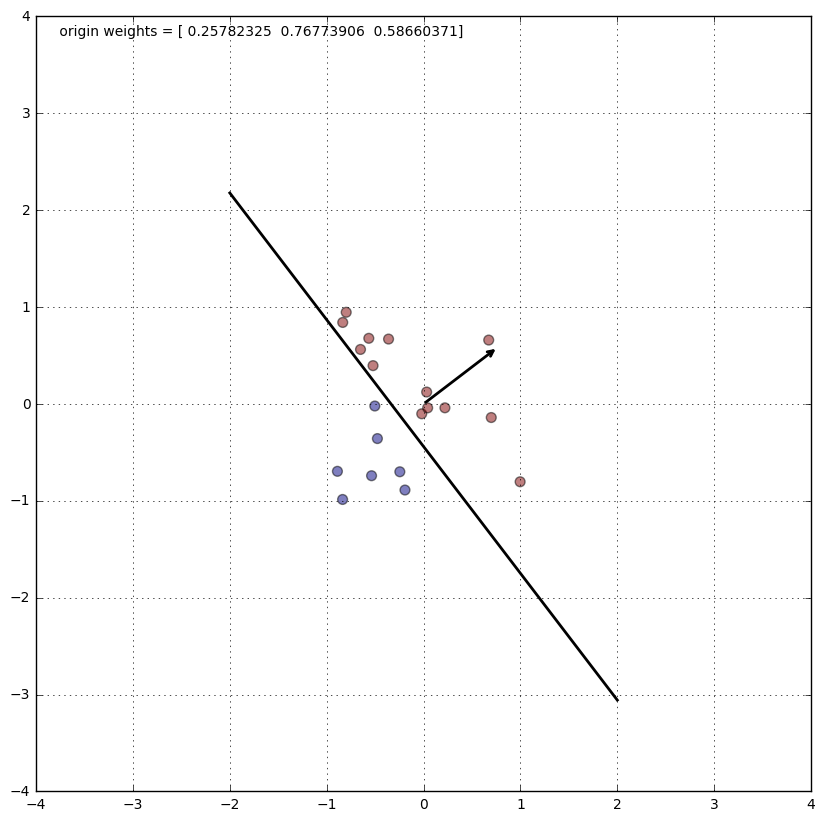

In [11]:
n = 40
d = 2
run_pla_animation(n, d)

### 选择第一个分类错误的点
在每次更新$w$的时候，选择的是随机的一个错误点，如果改成每次选择第一个分类错误的点，这样的话将会发生什么？

In [12]:
n = 200
d = 2
info_100_first = run_plas(times, n, d, choose_first_error=True)
print('times={0}, n={1}, d={2}, choose_first_error={3}'.format(times, n, d, True))
print(info_100_first.describe())

========================1=========================
iteration=130, train_accuracy=1.0, test_accuracy=0.99 
========================100=========================
iteration=1191, train_accuracy=1.0, test_accuracy=0.99 
========================200=========================
iteration=96, train_accuracy=1.0, test_accuracy=0.98 
========================300=========================
iteration=158, train_accuracy=1.0, test_accuracy=1.0 
========================400=========================
iteration=526, train_accuracy=1.0, test_accuracy=1.0 
========================500=========================
iteration=134, train_accuracy=1.0, test_accuracy=0.99 
========================600=========================
iteration=78, train_accuracy=1.0, test_accuracy=1.0 
========================700=========================
iteration=21, train_accuracy=1.0, test_accuracy=1.0 
========================800=========================
iteration=71, train_accuracy=1.0, test_accuracy=0.99 
========================900==========

这时，算法收敛需要的迭代次数变成了200+，几乎是原来的两倍，而且标准方差是原来的2倍多，其真正原因是什么呢？

### 如何提高PLA的收敛速度

这里还有一个问题，迭代次数的标准方差特别大，至少是200+，而且其分布呈现明显的右偏（均值>中位数>众数）。有什么办法能够减少这个方差呢？如果这可以做到，则可以提高PLA的收敛速度。已知的一种方法是利用线性回归先找到一个比较近似的结果$w$，然后把它作为初始值代入到PLA算法中，这样能够大大减少迭代的次数，并减少方差。

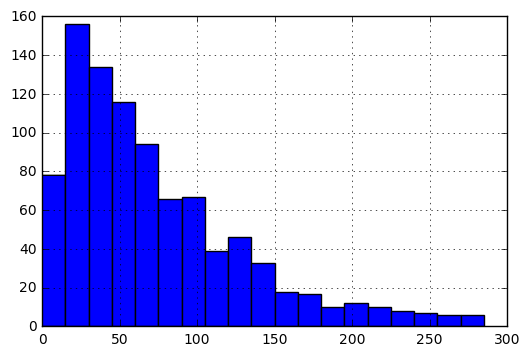

count     1000.000000
mean       137.131000
std        534.365963
min          2.000000
25%         31.000000
50%         62.000000
75%        119.250000
max      14456.000000
Name: iteration, dtype: float64


In [13]:
bins = np.arange(0., 300., 15.)
plt.hist(np.array(info_100['iteration'].values), bins)
plt.grid(True)
plt.show()
print(info_100['iteration'].describe())